In [15]:
import numpy as np
import pandas as pd
import shap
import lime
import lime.lime_tabular
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt



In [16]:
# 加载数据
file_path = './simulation_data.xlsx'
data = pd.read_excel(file_path)



In [17]:
# 数据分割
X = data.drop(columns='Score')
y = data['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



In [18]:
# 创建黑盒模型
black_box_model = make_pipeline(
    StandardScaler(),
    MLPRegressor(hidden_layer_sizes=(64, 32, 16), activation='relu', solver='adam', max_iter=1000, random_state=0)
)


In [19]:
# 训练模型
black_box_model.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=(64, 32, 16), max_iter=1000,
                              random_state=0))])

In [20]:
# 评估模型
train_r2 = black_box_model.score(X_train, y_train)
test_r2 = black_box_model.score(X_test, y_test)
print(f'Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}')


Train R2: 0.9743, Test R2: 0.9463


In [21]:
def predict_fn(X):
    return black_box_model.predict(X)


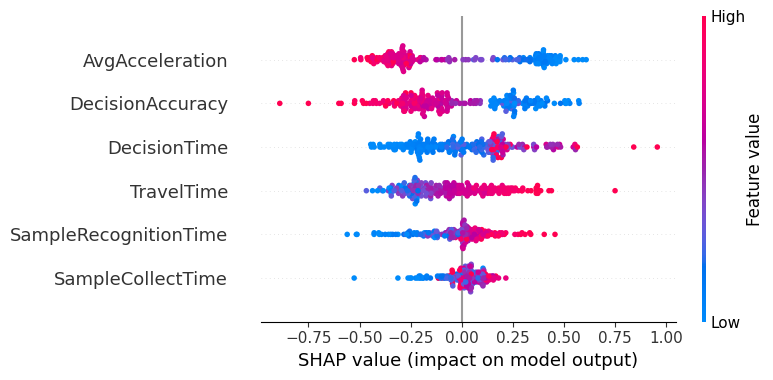

In [22]:

explainer = shap.Explainer(predict_fn, X_train)
shap_values = explainer(X_test)

# 绘制SHAP summary图
shap.summary_plot(shap_values.values, X_test, feature_names=X.columns)



In [27]:
# 使用LIME进行可解释性分析
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns,
    mode='regression'
)

# 解释一个样本
sample_id = 6
exp = lime_explainer.explain_instance(data_row=X_test.iloc[sample_id], predict_fn=black_box_model.predict)
exp.show_in_notebook(show_table=True)



X does not have valid feature names, but StandardScaler was fitted with feature names


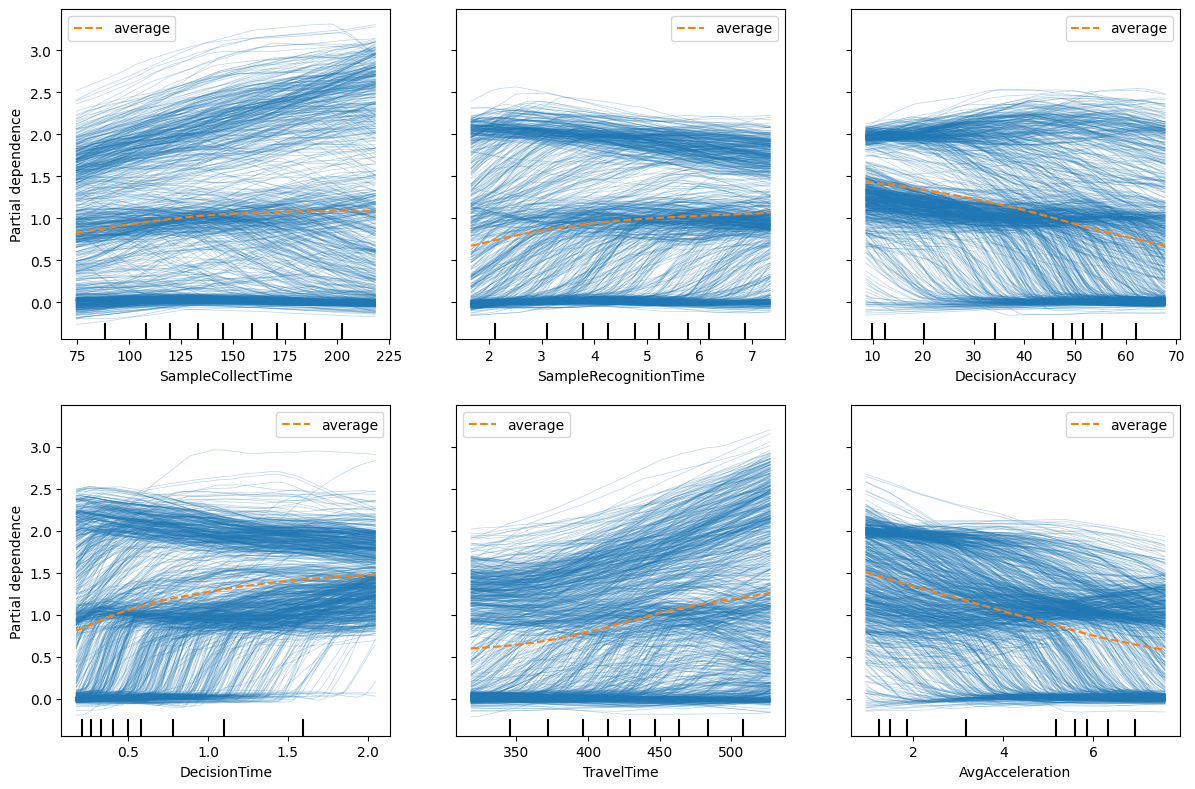

In [28]:
from sklearn.inspection import PartialDependenceDisplay

# 创建部分依赖图
fig, ax = plt.subplots(figsize=(12, 8))
features = [i for i in range(len(X_train.columns))]  # 选择要分析的特征索引
display = PartialDependenceDisplay.from_estimator(
    black_box_model,
    X_train,
    features,
    ax=ax,  # 指定matplotlib的axes对象
    kind="both"  # 显示平均效应和个体条件效应
)
plt.tight_layout()
plt.show()